# 6. Spam classification
## (a)

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [136]:
# %load 'data/spam_data/nb.py'
import numpy as np

def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)

def nb_train(matrix, category):
    state = {}
    V = matrix.shape[1]
    
    # split matrix
    mx1 = matrix[category == 1, :]
    mx0 = matrix[category == 0, :]
    
    # count the tokens of every file
    mx1_token_count = mx1.sum(axis = 1)
    mx0_token_count = mx0.sum(axis = 1)
    
    # calc the phi
    state['y_equal_1'] = (mx1.sum(axis = 0) + 1) / (mx1_token_count.sum(axis = 0) + V)
    state['y_equal_0'] = (mx0.sum(axis = 0) + 1) / (mx0_token_count.sum(axis = 0) + V)
    state['y_phi'] = mx1.shape[0] / matrix.shape[0]
    return state

def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    
    # calc p(x|y=0, 1)
    log_yeq_1 = matrix.dot(np.log(state['y_equal_1']))
    log_yeq_0 = matrix.dot(np.log(state['y_equal_0']))
    phi = state['y_phi']
    
    ratio = np.exp(log_yeq_0 + np.log(1 - phi) - log_yeq_1 - np.log(phi))
    prob = 1 / (1 + ratio)
    output[prob >= 0.5] = 1
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    return error

In [137]:
trainMatrix, tokenlist, trainCategory = readMatrix('data/spam_data/MATRIX.TRAIN')
testMatrix, tokenlist, testCategory = readMatrix('data/spam_data/MATRIX.TEST')

state = nb_train(trainMatrix, trainCategory)
output = nb_test(testMatrix, state)
print(evaluate(output, testCategory))

0.01625


## (b)

In [138]:
indic = np.log(state['y_equal_1'] / state['y_equal_0'])
np.array(tokenlist)[np.argsort(indic)[:-5:-1]]

array(['httpaddr', 'spam', 'unsubscrib', 'ebai'], dtype='<U16')

## (c)

0.03875
0.02625
0.02625
0.01875
0.0175
0.01625


Text(0, 0.5, 'Test Error (%)')

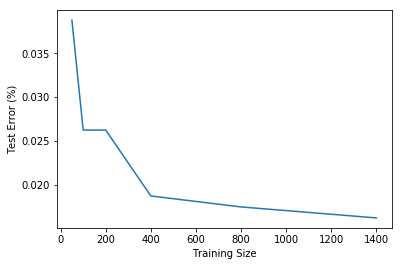

In [139]:
size = [50, 100, 200, 400, 800, 1400]
error_list_nb = []
testMatrix, tokenlist, testCategory = readMatrix('data/spam_data/MATRIX.TEST')
for (i, num) in enumerate(size):
    trainMatrix, tokenlist, trainCategory = readMatrix('data/spam_data/MATRIX.TRAIN.' + str(num))
    state = nb_train(trainMatrix, trainCategory)
    output = nb_test(testMatrix, state)
    error = evaluate(output, testCategory)
    error_list_nb.append(error)
    print(error)
plt.plot(size, error_list_nb)
plt.xlabel('Training Size')
plt.ylabel('Test Error (%)')

## (d)

In [140]:
# %load 'data/spam_data/svm.py'
import numpy as np

tau = 8.

def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category

def svm_train(matrix, category):
    state = {}
    M, N = matrix.shape
    #####################
    Y = category
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(matrix.T)
    K = np.exp(-(squared.reshape((1, -1)) + squared.reshape((-1, 1)) - 2 * gram) / (2 * (tau ** 2)) )

    alpha = np.zeros(M)
    alpha_avg = np.zeros(M)
    L = 1. / (64 * M)
    outer_loops = 40

    alpha_avg
    for ii in range(outer_loops * M):
        i = int(np.random.rand() * M)
        margin = Y[i] * np.dot(K[i, :], alpha)
        grad = M * L * K[:, i] * alpha[i]
        if (margin < 1):
            grad -=  Y[i] * K[:, i]
        alpha -=  grad / np.sqrt(ii + 1)
        alpha_avg += alpha

    alpha_avg /= (ii + 1) * M

    state['alpha'] = alpha
    state['alpha_avg'] = alpha_avg
    state['Xtrain'] = matrix
    state['Sqtrain'] = squared
    ####################
    return state

def svm_test(matrix, state):
    M, N = matrix.shape
    output = np.zeros(M)
    ###################
    Xtrain = state['Xtrain']
    Sqtrain = state['Sqtrain']
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(Xtrain.T)
    K = np.exp(-(squared.reshape((-1, 1)) + Sqtrain.reshape((1, -1)) - 2 * gram) / (2 * (tau ** 2)))
    alpha_avg = state['alpha_avg']
    preds = K.dot(alpha_avg)
    output = np.sign(preds)
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print ('Error: %1.4f' % error)
    return error

Error: 0.0288
Error: 0.0250
Error: 0.0025
Error: 0.0025
Error: 0.0000
Error: 0.0000


Text(0, 0.5, 'Test Error (%)')

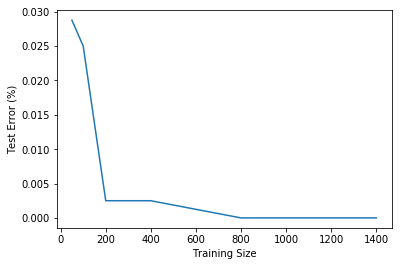

In [143]:
size = [50, 100, 200, 400, 800, 1400]
error_list_svm = []
testMatrix, tokenlist, testCategory = readMatrix('data/spam_data/MATRIX.TEST')
for (i, num) in enumerate(size):
    trainMatrix, tokenlist, trainCategory = readMatrix('data/spam_data/MATRIX.TRAIN.' + str(num))
    state = svm_train(trainMatrix, trainCategory)
    output = svm_test(testMatrix, state)
    error = evaluate(output, testCategory)
    error_list_svm.append(error)
plt.plot(size, error_list_svm)
plt.xlabel('Training Size')
plt.ylabel('Test Error (%)')

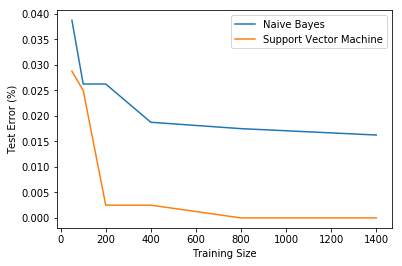

In [146]:
plt.plot(size, error_list_nb, label="Naive Bayes")
plt.plot(size, error_list_svm, label="Support Vector Machine")
plt.xlabel('Training Size')
plt.ylabel('Test Error (%)')
plt.legend()

SVM performs better overall